# Lab 01 : Point Cloud Classification - solution

The goal is to implement an architecture that classifies point clouds.</br>

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_codes/codes/labs_lecture13'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time

In [3]:
#device= torch.device("cuda")
device= torch.device("cpu")
print(device)

cpu


### Generate the dataset 

In [4]:
# Libraries
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings

# Import 5 object types
ob_size = 11
objects = torch.zeros(5,ob_size,ob_size)
nb_class_objects = 5
for k in range(nb_class_objects):
    objects[k,:,:] = 1-ToTensor()(Image.open('objects/obj'+str(k+1)+'.tif'))[0,:,:]
print(objects.size())

torch.Size([5, 11, 11])


torch.Size([2, 28, 28])
torch.Size([2, 35, 2])
torch.Size([2])


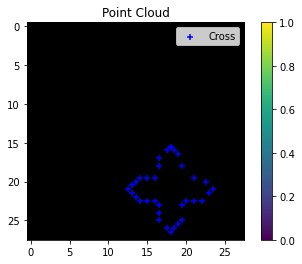

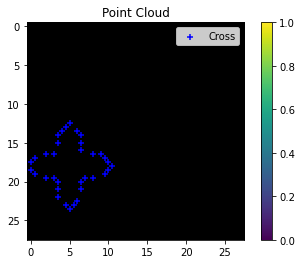

In [5]:
# Define the bounding boxes w.r.t. object type
def obj_legend(label):
    if label==0:
        color = 'r'; legend = 'Triangle'
    elif label==1:
        color = 'b'; legend = 'Cross'
    elif label==2:
        color = 'g'; legend = 'Star'
    elif label==3:
        color = 'y'; legend = 'Square'
    elif label==4:
        color = 'm'; legend = 'Ring'
    return color, legend

# Global constants
# im_size = image size  
# ob_size = object size
# batch_size = batch size
# nb_object_classes = number of object classes (we have 5 classes)
im_size = 28 
batch_size = 2
nb_object_classes = 5
nb_points = 35 # min=41 max=66

# Function that generate a batch of training data
def generate_batch_data(im_size, ob_size, batch_size, nb_points, nb_object_classes):
    batch_images = torch.zeros(batch_size,im_size,im_size)
    batch_points = torch.zeros(batch_size,nb_points,2)
    batch_labels = torch.zeros(batch_size)
    for b in range(batch_size):
        image = torch.zeros(im_size,im_size) 
        class_object = torch.LongTensor(1).random_(0,nb_object_classes)        
        offset = (ob_size-1)// 2 + 0
        coord_objects = torch.LongTensor(2).random_(offset,im_size-offset)
        # coord_objects[0] = x-coordinate,  coord_objects[1] = y-coordinate
        image[coord_objects[1]-offset:coord_objects[1]-offset+ob_size,coord_objects[0]-offset:coord_objects[0]-offset+ob_size] = objects[class_object,:,:]
        # find x,y s.t. image[y,x]=0.5
        obj_yx = torch.Tensor(plt.contour(image, [0.5]).collections[0].get_paths()[0].vertices); plt.clf() 
        obj_yx[:,[0,1]] = obj_yx[:,[1,0]]
        if class_object==4: # get the interior for the ring shape
            obj_yx_tmp = torch.Tensor(plt.contour(image, [0.5]).collections[0].get_paths()[1].vertices); plt.clf() 
            obj_yx_tmp[:,[0,1]] = obj_yx_tmp[:,[1,0]]
            obj_yx = torch.cat((obj_yx,obj_yx_tmp),dim=0)
        nb_yx_pts = obj_yx.size(0)
        if nb_yx_pts>=nb_points:
            idx_perm = torch.randperm(nb_yx_pts)[:nb_points]
            obj_yx = obj_yx[idx_perm,:]
        else: # in case of plt.contour does not extract enough data points
            obj_yx = obj_yx.repeat_interleave(nb_points//nb_yx_pts+1,dim=0)[:nb_points]
        batch_images[b,:,:] = image
        batch_points[b,:,:] = obj_yx
        batch_labels[b] = class_object
    return batch_images, batch_points, batch_labels

# Plot a mini-batch of images
batch_images, batch_points, batch_labels = generate_batch_data(im_size, ob_size, batch_size, nb_points, nb_object_classes)
print(batch_images.size())
print(batch_points.size())
print(batch_labels.size())
for b in range(batch_size):
    #plt.imshow(batch_images[b,:,:], cmap='gray')
    plt.imshow(torch.zeros(im_size,im_size), cmap='gray')
    color, legend = obj_legend(batch_labels[b])
    plt.scatter(batch_points[b,:,1],batch_points[b,:,0],marker='+',color=color,label=legend)
    plt.legend(loc='best')
    plt.colorbar()
    plt.title('Point Cloud')
    #plt.axis('off')
    plt.show() 


In [6]:
# Define the cloud network architecture
batch_size = 2 # for debug

class cloudNN(nn.Module):
    
    def __init__(self):
        super(cloudNN, self).__init__()
        # COMPLETE HERE
        hidden_dim = 250
        # first set layer
        self.linear_set1 = nn.Linear(2,  hidden_dim, bias=True) #  2 --> hidden_dim
        # second set layer
        self.linear_set2 = nn.Linear(hidden_dim,  hidden_dim, bias=True) #  hidden_dim --> hidden_dim
        # classification layer
        self.linear_class = nn.Linear(hidden_dim,  nb_object_classes, bias=True) #  hidden_dim --> nb_object_classes
        
    def forward(self, x): 
        # COMPLETE HERE
        # first set layer
        x = self.linear_set1(x) # [batch_size, nb_points, 50] = [2, 45, 50] 
        x_sum = torch.sum(x, dim=1).unsqueeze(dim=1) # [batch_size, nb_points, 50] = [2, 1, 50] 
        x = x - x_sum/nb_points # [batch_size, nb_points, 50] = [2, 45, 50] 
        x = torch.relu(x)
        # second set layer
        x = self.linear_set2(x) # [batch_size, nb_points, 50] = [2, 45, 50] 
        x_sum = torch.sum(x, dim=1).unsqueeze(dim=1) # [batch_size, nb_points, 50] = [2, 1, 50] 
        x = x - x_sum/nb_points # [batch_size, nb_points, 50] = [2, 45, 50] 
        x = torch.relu(x)
        # classification layer
        x = torch.sum(x, dim=1) # [batch_size, 50] = [2, 50] 
        scores_cloud_class = self.linear_class(x) # [batch_size, nb_object_classes] = [2, 5]
        return scores_cloud_class
    
# Instantiate the network
net = cloudNN()
net = net.to(device)
print(net)
utils.display_num_param(net) 

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
batch_images, batch_points, batch_labels = generate_batch_data(im_size, ob_size, batch_size, nb_points, nb_object_classes)
optimizer.zero_grad()
scores_cloud_class = net(batch_points) # [batch_size, nb_object_classes] = [2, 5]
batch_labels = batch_labels.long() # [batch_size] = [2]
# loss
loss = nn.CrossEntropyLoss()(scores_cloud_class, batch_labels)
loss.backward()
optimizer.step()


cloudNN(
  (linear_set1): Linear(in_features=2, out_features=250, bias=True)
  (linear_set2): Linear(in_features=250, out_features=250, bias=True)
  (linear_class): Linear(in_features=250, out_features=5, bias=True)
)
There are 64755 (0.06 million) parameters in this neural network


<Figure size 432x288 with 0 Axes>

In [7]:
# Training loop
net = cloudNN()
net = net.to(device)
utils.display_num_param(net) 

# Optimizer
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)

# Number of mini-batches per epoch
nb_batch = 10
batch_size = 10

start=time.time()
for epoch in range(10):

    running_loss = 0.0
    num_batches = 0
    
    for _ in range(nb_batch):
        
        # FORWARD AND BACKWARD PASS
        batch_images, batch_points, batch_labels = generate_batch_data(im_size, ob_size, batch_size, nb_points, nb_object_classes)
        optimizer.zero_grad()
        scores_cloud_class = net(batch_points) # [batch_size, nb_object_classes] = [2, 5]
        batch_labels = batch_labels.long() # [batch_size] = [2]
        # loss
        loss = nn.CrossEntropyLoss()(scores_cloud_class, batch_labels)
        loss.backward()
        optimizer.step()

        # COMPUTE STATS
        running_loss += loss.detach().item()
        num_batches += 1        
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss=', total_loss )
    

There are 64755 (0.06 million) parameters in this neural network
epoch= 0 	 time= 0.06920528809229533 min 	 lr= 0.001 	 loss= 4.997068619728088
epoch= 1 	 time= 0.14382816950480143 min 	 lr= 0.001 	 loss= 3.845940363407135
epoch= 2 	 time= 0.21752860148747763 min 	 lr= 0.001 	 loss= 1.8023644089698792
epoch= 3 	 time= 0.28922005494435626 min 	 lr= 0.001 	 loss= 0.7391521468758583
epoch= 4 	 time= 0.37003350257873535 min 	 lr= 0.001 	 loss= 0.47985111698508265
epoch= 5 	 time= 0.43985991875330605 min 	 lr= 0.001 	 loss= 0.2780929982662201
epoch= 6 	 time= 0.513493804136912 min 	 lr= 0.001 	 loss= 0.46808040887117386
epoch= 7 	 time= 0.5825511336326599 min 	 lr= 0.001 	 loss= 0.4530162125825882
epoch= 8 	 time= 0.6523229002952575 min 	 lr= 0.001 	 loss= 0.16606513932347297
epoch= 9 	 time= 0.7216811696688334 min 	 lr= 0.001 	 loss= 0.20142860859632492


<Figure size 432x288 with 0 Axes>

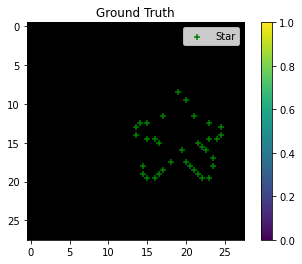

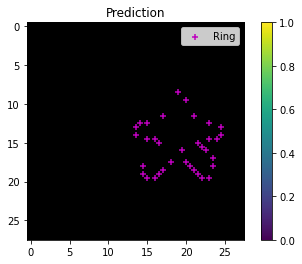

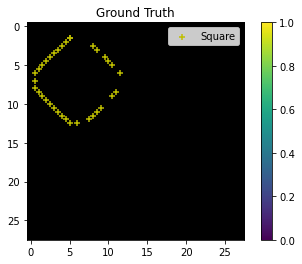

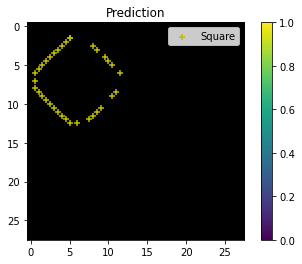

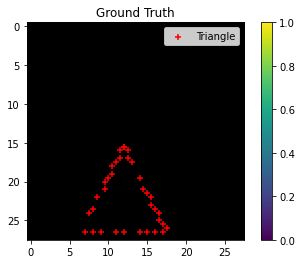

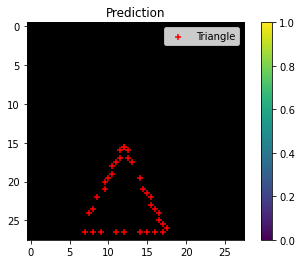

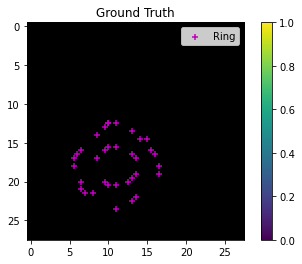

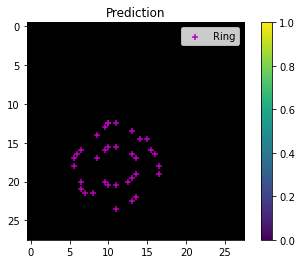

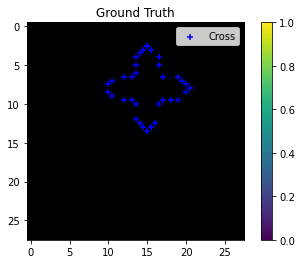

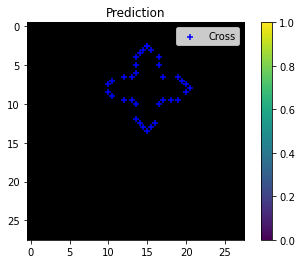

In [8]:
# Test time

# select a batch of 2 images
batch_size = 5

# generate the batch of 2 images
batch_images, batch_points, batch_labels = generate_batch_data(im_size, ob_size, batch_size, nb_points, nb_object_classes)
        
# forward pass
scores_cloud_class = net(batch_points) # [batch_size, nb_object_classes]

# class prediction
pred_cloud_class = torch.argmax(scores_cloud_class, dim=1) # [batch_size] 

# Plot the ground truth solution and the predicted solution
for b in range(batch_size):

    #plt.imshow(batch_images[b,:,:], cmap='gray')
    plt.imshow(torch.zeros(im_size,im_size), cmap='gray')
    color, legend = obj_legend(batch_labels[b])
    plt.scatter(batch_points[b,:,1],batch_points[b,:,0],marker='+',color=color,label=legend)
    plt.legend(loc='best')
    plt.colorbar()
    plt.title('Ground Truth')
    plt.show() 
    
    #plt.imshow(batch_images[b,:,:], cmap='gray')
    plt.imshow(torch.zeros(im_size,im_size), cmap='gray')
    color, legend = obj_legend(pred_cloud_class[b])
    plt.scatter(batch_points[b,:,1],batch_points[b,:,0],marker='+',color=color,label=legend)
    plt.legend(loc='best')
    plt.colorbar()
    plt.title('Prediction')
    plt.show() 
    